In [1]:
import numpy as np
from filterpy.kalman import ExtendedKalmanFilter, UnscentedKalmanFilter, MerweScaledSigmaPoints

# 定义系统模型
def fx(x, dt):
    # 状态转移函数：x = [x, y, vx, vy]
    F = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    return np.dot(F, x)

def hx(x):
    # 观测函数：z = [x, y]
    return np.array([x[0], x[1]])

# 初始化EKF
ekf = ExtendedKalmanFilter(dim_x=4, dim_z=2)
ekf.x = np.array([0, 0, 1, 1])  # 初始状态 [x, y, vx, vy]
ekf.P = np.eye(4) * 100  # 初始协方差矩阵
ekf.R = np.eye(2) * 1  # 观测噪声协方差
ekf.Q = np.eye(4) * 0.1  # 过程噪声协方差

# 初始化UKF
points = MerweScaledSigmaPoints(4, alpha=1e-3, beta=2, kappa=0)
ukf = UnscentedKalmanFilter(dim_x=4, dim_z=2, dt=0.1, fx=fx, hx=hx, points=points)
ukf.x = np.array([0, 0, 1, 1])  # 初始状态 [x, y, vx, vy]
ukf.P = np.eye(4) * 100  # 初始协方差矩阵
ukf.R = np.eye(2) * 1  # 观测噪声协方差
ukf.Q = np.eye(4) * 0.1  # 过程噪声协方差

# 模拟数据
dt = 0.1
true_state = np.array([0, 0, 1, 1])
measurements = []
for _ in range(50):
    true_state = fx(true_state, dt)
    z = hx(true_state) + np.random.randn(2) * 0.1  # 添加噪声
    measurements.append(z)

# EKF和UKF的估计
ekf_states = []
ukf_states = []
for z in measurements:
    ekf.predict()
    ekf.update(z, HJacobian=lambda x: np.array([[1, 0, 0, 0], [0, 1, 0, 0]]), Hx=hx)
    ekf_states.append(ekf.x.copy())
    
    ukf.predict()
    ukf.update(z)
    ukf_states.append(ukf.x.copy())

# 输出结果
print("EKF估计的最终状态:", ekf_states[-1])
print("UKF估计的最终状态:", ukf_states[-1])



EKF估计的最终状态: [4.72969389 4.6793225  1.         1.        ]
UKF估计的最终状态: [5.00365119 4.9334938  1.01773249 0.93163922]


# SLAM

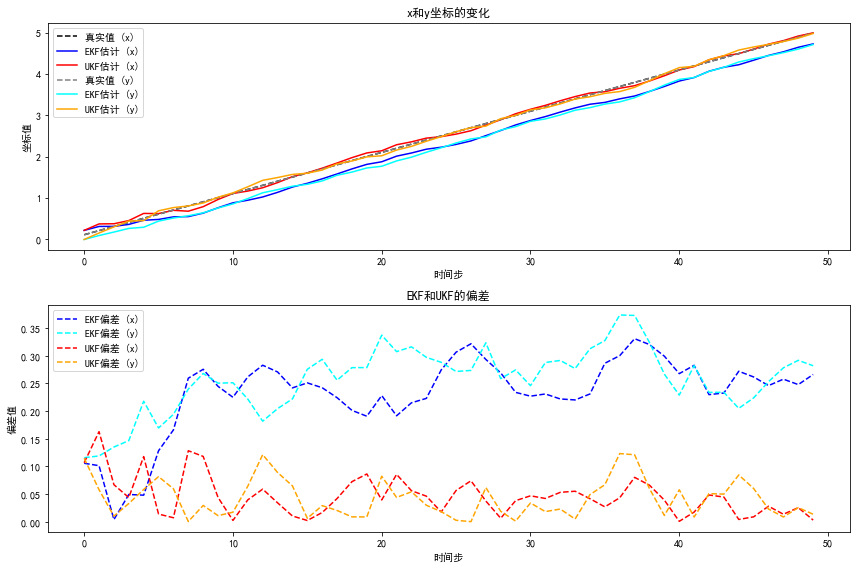

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import ExtendedKalmanFilter, UnscentedKalmanFilter, MerweScaledSigmaPoints

# 定义系统模型
def fx(x, dt):
    # 状态转移函数：x = [x, y, vx, vy]
    F = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    return np.dot(F, x)

def hx(x):
    # 观测函数：z = [x, y]
    return np.array([x[0], x[1]])

# 初始化EKF
ekf = ExtendedKalmanFilter(dim_x=4, dim_z=2)
ekf.x = np.array([0, 0, 1, 1])  # 初始状态 [x, y, vx, vy]
ekf.P = np.eye(4) * 100  # 初始协方差矩阵
ekf.R = np.eye(2) * 1  # 观测噪声协方差
ekf.Q = np.eye(4) * 0.1  # 过程噪声协方差

# 初始化UKF
points = MerweScaledSigmaPoints(4, alpha=1e-3, beta=2, kappa=0)
ukf = UnscentedKalmanFilter(dim_x=4, dim_z=2, dt=0.1, fx=fx, hx=hx, points=points)
ukf.x = np.array([0, 0, 1, 1])  # 初始状态 [x, y, vx, vy]
ukf.P = np.eye(4) * 100  # 初始协方差矩阵
ukf.R = np.eye(2) * 1  # 观测噪声协方差
ukf.Q = np.eye(4) * 0.1  # 过程噪声协方差

# 模拟数据
dt = 0.1
true_state = np.array([0, 0, 1, 1])
true_states = []
measurements = []
for _ in range(50):
    true_state = fx(true_state, dt)
    true_states.append(true_state.copy())
    z = hx(true_state) + np.random.randn(2) * 0.1  # 添加噪声
    measurements.append(z)

# EKF和UKF的估计
ekf_states = []
ukf_states = []
for z in measurements:
    ekf.predict()
    ekf.update(z, HJacobian=lambda x: np.array([[1, 0, 0, 0], [0, 1, 0, 0]]), Hx=hx)
    ekf_states.append(ekf.x.copy())
    
    ukf.predict()
    ukf.update(z)
    ukf_states.append(ukf.x.copy())

# 将结果转换为NumPy数组以便绘图
true_states = np.array(true_states)
ekf_states = np.array(ekf_states)
ukf_states = np.array(ukf_states)

# 计算偏差
ekf_errors_x = np.abs(ekf_states[:, 0] - true_states[:, 0])
ekf_errors_y = np.abs(ekf_states[:, 1] - true_states[:, 1])
ukf_errors_x = np.abs(ukf_states[:, 0] - true_states[:, 0])
ukf_errors_y = np.abs(ukf_states[:, 1] - true_states[:, 1])

# 可视化结果
plt.figure(figsize=(12, 8))

plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 第一张图：x和y坐标的变化
plt.subplot(2, 1, 1)
plt.plot(true_states[:, 0], label='真实值 (x)', linestyle='--', color='black')
plt.plot(ekf_states[:, 0], label='EKF估计 (x)', color='blue')
plt.plot(ukf_states[:, 0], label='UKF估计 (x)', color='red')
plt.plot(true_states[:, 1], label='真实值 (y)', linestyle='--', color='gray')
plt.plot(ekf_states[:, 1], label='EKF估计 (y)', color='cyan')
plt.plot(ukf_states[:, 1], label='UKF估计 (y)', color='orange')
plt.title('x和y坐标的变化')
plt.xlabel('时间步')
plt.ylabel('坐标值')
plt.legend()

# 第二张图：EKF和UKF的偏差
plt.subplot(2, 1, 2)
plt.plot(ekf_errors_x, label='EKF偏差 (x)', color='blue', linestyle='--')
plt.plot(ekf_errors_y, label='EKF偏差 (y)', color='cyan', linestyle='--')
plt.plot(ukf_errors_x, label='UKF偏差 (x)', color='red', linestyle='--')
plt.plot(ukf_errors_y, label='UKF偏差 (y)', color='orange', linestyle='--')
plt.title('EKF和UKF的偏差')
plt.xlabel('时间步')
plt.ylabel('偏差值')
plt.legend()

plt.tight_layout()
plt.show()


## UKF和EKF仿真场景和意义

### 场景描述

在这段代码中，我们模拟了一个简单的二维运动模型，其中状态向量 \( x \) 包含位置 \( (x, y) \) 和速度 \( (vx, vy) \)。系统的状态转移函数 \( fx \) 和观测函数 \( hx \) 被定义，并且使用EKF和UKF进行状态估计。

### 意义

- **EKF**：通过线性化非线性函数来处理非线性系统，适用于系统模型可以被较好地线性化的情况。
- **UKF**：通过使用Sigma点来捕捉非线性系统的统计特性，通常在处理高度非线性系统时比EKF提供更高的精度。

### 公式说明

#### 状态转移函数 \( fx \) 和观测函数 \( hx \)

- 状态转移函数：
  \[ x_{k+1} = \begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} x_k \]

- 观测函数：
  \[ z_k = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix} x_k \]

#### EKF更新步骤

1. **预测**：
   \[ x_{k|k-1} = \begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} x_{k-1|k-1} \]
   \[ P_{k|k-1} = \begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} P_{k-1|k-1} \begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}^T + Q_k \]

2. **更新**：
   \[ K_k = P_{k|k-1} \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix}^T \left( \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} + \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix} P_{k|k-1} \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix}^T \right)^{-1} \]
   \[ x_{k|k} = x_{k|k-1} + K_k (z_k - \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix} x_{k|k-1}) \]
   \[ P_{k|k} = \left( I - K_k \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix} \right) P_{k|k-1} \]

#### UKF更新步骤

1. **Sigma点生成**：
   \[ \lambda = \alpha^2 (\dim x) - 1 \]
   \[ X_0 = x \]
   \[ X_i = x + \sqrt{\lambda P} \quad \text{for } i = 1, \ldots, \dim x \]
   \[ X_{\dim x + i} = x - \sqrt{\lambda P} \quad \text{for } i = 1, \ldots, \dim x \]

2. **Sigma点传播**：
   \[ X_i^{+} = fx(X_i, \Delta t) \]

3. **预测状态和协方差**：
   \[ \hat{x}_{k|k-1} = \sum W_m^{(i)} X_i^{+} \]
   \[ P_{k|k-1} = \sum W_c^{(i)} (X_i^{+} - \hat{x}_{k|k-1})(X_i^{+} - \hat{x}_{k|k-1})^T + Q \]

4. **预测观测和协方差**：
   \[ Z_i^{+} = hx(X_i^{+}) \]
   \[ \hat{z}_{k|k-1} = \sum W_m^{(i)} Z_i^{+} \]
   \[ P_{zz} = \sum W_c^{(i)} (Z_i^{+} - \hat{z}_{k|k-1})(Z_i^{+} - \hat{z}_{k|k-1})^T + R \]
   \[ P_{xz} = \sum W_c^{(i)} (X_i^{+} - \hat{x}_{k|k-1})(Z_i^{+} - \hat{z}_{k|k-1})^T \]

5. **更新状态和协方差**：
   \[ K_k = P_{xz} P_{zz}^{-1} \]
   \[ \hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k (z_k - \hat{z}_{k|k-1}) \]
   \[ P_{k|k} = P_{k|k-1} - K_k P_{zz} K_k^T \]

### 图示结果分析

根据提供的图示，我们可以进行以下分析：

1. **上图（状态估计）**：
   - 实线（黑色虚线）表示真实状态。
   - 蓝色实线表示EKF对状态 \( x \) 的估计。
   - 红色实线表示UKF对状态 \( x \) 的估计。
   - 青色实线表示EKF对状态 \( y \) 的估计。
   - 黄色实线表示UKF对状态 \( y \) 的估计。

2. **下图（偏差分析）**：
   - 蓝色虚线表示EKF对状态 \( x \) 的偏差。
   - 青色虚线表示EKF对状态 \( y \) 的偏差。
   - 红色虚线表示UKF对状态 \( x \) 的偏差。
   - 黄色虚线表示UKF对状态 \( y \) 的偏差。

### 结论

在本仿真场景下，UKF在跟踪真实状态和减少估计偏差方面表现优于EKF。这可能是因为UKF通过Sigma点更好地处理了系统的非线性特性。然而，EKF由于其计算简单性，在某些实时性要求较高的应用中可能更受欢迎。选择哪种算法取决于具体应用的需求和系统特性。
